# dimensionality

Investigate how the average distance between a set of points changes as the dimensionality of the space increases.

## Packages for computation and data manipulation

In [1]:
import numpy as np # for number crunching
import pandas as pd # for data loading and manipulation
import time
import pickle
import re
import random
import itertools
from itertools import groupby
import collections
from collections import Counter
from collections import defaultdict
from datetime import datetime, timedelta
import string
import io

from scipy.spatial import distance
from scipy.spatial.distance import cdist
from scipy.spatial import Voronoi # for showing cluster boundaries

from sklearn.metrics import pairwise_distances

# Plotting
# Import the pyplot module from the matplotlib library
from matplotlib import pyplot as plt
import seaborn as sns

## Approach

 - Generate an array of vectors with array size m rows and n columns
 - These arrays can be of two kinds.
  - Case 1: The first kind of array is when each vector in the array is the same as every other vector in the array. This is the case in which we start out with n points in a one-dimensional space and ask how these same points are distributed as we increase the dimensions. Same points, 
  - Case 2: The second kind of array is when each vector in the array is different from every other vector in the array. This is the general case of having the same number of points but the points in each dimension are different from the points in the higher dimension. Intuitively, this is not the case that we want. 
 - Case 1
  - Generate an m x n array where the row vectors are exactly the same. Use the repeat_array function with repeat_array=1.
  - Find the average distance between the points on a single vector. 
  - Then take a 2, 3, 4, ... m vectors and transpose them. This will render them in the form that the same set of points are being put into higher dimensions. Find the average pairwise distance between these vectors. This measures the way in which dimensionality makes distances greater and washes out similarity because ultimately everything is sufficiently far from everthing.

In [2]:
def create_data_array(m_rows, n_cols, repeat_array=0):
    '''
    Create an num_rows x num_cols array of random values in the interval (0, 1]. 
    num_rows is the dimensionality of the space and num_cols is the number of points 
    along any single dimension.
    
    When repeat_array = 0 (default), the rows contain differnt vectors. E.g., [[0.1, 0.2], [0.5, 0.8], [0.2, 0.7]]
    When repeat_array = 1, the rows all contain the same vector. E.g., [[0.1, 0.2], [0.1, 0.2], [0.1, 0.2]]
    
    REQUIRES numpy, random
    
    '''
    if repeat_array == 1:
        # Create the base vector
        vec = np.random.random_sample(size=(1, n_cols))
        # Create num_rows replicas of vec to form the array
        vec_array = np.repeat(vec, m_rows, axis=0)
    else:
        vec_array = np.random.random_sample(size=(m_rows, n_cols))
        
    return vec_array

In [3]:
vec_array = create_data_array(20,4,repeat_array=0)
vec_array

array([[3.54136499e-01, 6.44214904e-01, 5.33628662e-01, 4.60433570e-01],
       [3.50989123e-01, 1.75438944e-01, 2.41365843e-01, 2.92183787e-01],
       [5.17171857e-03, 1.03818093e-01, 9.00047545e-01, 2.00989144e-04],
       [4.12592150e-01, 9.09737353e-01, 9.33975707e-02, 8.39118305e-01],
       [5.49826340e-01, 1.06700963e-01, 6.96399551e-01, 6.01072451e-02],
       [3.55081130e-01, 4.82942404e-01, 1.71258904e-01, 8.31701780e-01],
       [8.71908649e-01, 2.67580380e-01, 5.25352520e-01, 4.27823637e-01],
       [7.23781552e-01, 8.80758727e-01, 1.10286314e-01, 1.34769143e-02],
       [5.54517272e-02, 7.49049754e-01, 5.76046102e-01, 5.03563171e-01],
       [8.21524422e-01, 9.21713262e-01, 1.27588414e-02, 4.38537632e-01],
       [9.65060625e-01, 5.12971389e-01, 7.51652905e-01, 1.12349881e-01],
       [3.83133588e-01, 6.28754340e-01, 8.36154428e-01, 8.66035244e-01],
       [1.89941530e-01, 1.68416739e-01, 2.91025336e-01, 7.70322066e-01],
       [4.44107600e-01, 7.82322533e-01, 9.91678765e

In [4]:
def single_vector_distances(vector):
    '''
    Given a vector such as [0.2, 0.3, 0.76], find the pairwise distances between
    the elements. Calculate the descriptive stats for these pairwise distances -- max, min, mean, and std dev.
    
    REQUIRES numpy
    
    '''
    # Get the pairwise distances as a one-dimensional array
    pairwise_dists = np.reshape([np.abs(vector[i] - vector[j]) for i in range(len(vector)) for j in range(len(vector))], (1, -1))[0]
    
    # Remove the zeros from the pairwise_distances vector 
    ## This ensures that the mean is larger than it would otherwise be and accurately reflects how average distances
    ## between points grows as dimensionality increases.
    
    non_zero_distances = [x for x in pairwise_dists if x > 0]
    
    return [np.mean(non_zero_distances), np.std(non_zero_distances), np.max(non_zero_distances), np.min(non_zero_distances)]

In [5]:
single_vector_distances(vec_array[0])

[0.15723838461730125,
 0.0715086763150385,
 0.2900784051148362,
 0.07319509235929889]

In [6]:
vec_array_test = vec_array[0:21]
vec_array_test

array([[3.54136499e-01, 6.44214904e-01, 5.33628662e-01, 4.60433570e-01],
       [3.50989123e-01, 1.75438944e-01, 2.41365843e-01, 2.92183787e-01],
       [5.17171857e-03, 1.03818093e-01, 9.00047545e-01, 2.00989144e-04],
       [4.12592150e-01, 9.09737353e-01, 9.33975707e-02, 8.39118305e-01],
       [5.49826340e-01, 1.06700963e-01, 6.96399551e-01, 6.01072451e-02],
       [3.55081130e-01, 4.82942404e-01, 1.71258904e-01, 8.31701780e-01],
       [8.71908649e-01, 2.67580380e-01, 5.25352520e-01, 4.27823637e-01],
       [7.23781552e-01, 8.80758727e-01, 1.10286314e-01, 1.34769143e-02],
       [5.54517272e-02, 7.49049754e-01, 5.76046102e-01, 5.03563171e-01],
       [8.21524422e-01, 9.21713262e-01, 1.27588414e-02, 4.38537632e-01],
       [9.65060625e-01, 5.12971389e-01, 7.51652905e-01, 1.12349881e-01],
       [3.83133588e-01, 6.28754340e-01, 8.36154428e-01, 8.66035244e-01],
       [1.89941530e-01, 1.68416739e-01, 2.91025336e-01, 7.70322066e-01],
       [4.44107600e-01, 7.82322533e-01, 9.91678765e

In [7]:
def multiple_vector_distances(vector_array): 
    '''
    Given a vector_array such as such as [[0.2, 0.3, 0.76],[0.2, 0.3, 0.76],[0.2, 0.3, 0.76]] 
    (in this case each vector in the array is the same, but they don't have to be), find the 
    pairwise distances between each vector in the vector_array. 
    
    Calculate the descriptive statistics for the pairwise distances -- mean, std dev, max, and min.
    OBSERVATION: The length of the vector_array is a measure of the dimensionality of the space.
    
    REQUIRES numpy, from sklearn.metrics import pairwise_distances
    
    '''
    
    # First transpose the vector_array
    ## This ensures that when the vectors are the same the 
    ## same points that are on a single dimension are represented in multiple dimensiions. 
    ## When the vectors in the vector_array are different we don't have to transpose -- but it doesn't change
    ## anything and it keeps the code simpler to handle both types of vector_arrays with a single function.
    vec_array_transp = np.transpose(vector_array)
    
    # Find the pairwise distances between each vector in the array 
    ## and flatten the array into a one-row vector
    pairwise_dists = np.reshape(pairwise_distances(vec_array_transp), (1, -1))[0]
    
    # Drop the zeros
    non_zero_distances = [x for x in pairwise_dists if x > 0]
    
    # Return the descriptive stats
    return [np.mean(non_zero_distances), np.std(non_zero_distances), np.max(non_zero_distances), np.min(non_zero_distances)]

In [8]:
multiple_vector_distances(vec_array_test)

[1.883763413555826, 0.14498886324963212, 2.067911281833139, 1.6814071853804193]

## How does the average distance between points vary as dimensionality increases? 

In [25]:
def distance_per_dimension(num_points, num_dims, repeat_array=1):
    '''
    Imagine you have num_points number of points on a line. These are randomly generated points in 
    the interval (0.0, 1.0]. What happens to the average distance between these points as they are placed
    in spaces with dimensions from 1 to num_dims?
    
    USES single_vector_distances, multiple_vector_distances
    
    REQUIRES seaborn, matplotlib, pandas
    
    '''
    t0 = time.time()
    
    # Create a vector array
    ## The value of m_rows is the number of dimensions and n_cols the number of points for which
    ## we calculate the results.
    vector_array = create_data_array(m_rows=num_dims, n_cols=num_points, repeat_array=repeat_array)

    # Starting with dimensionality = 1 and ending with dimensionality = m_rows, find the 
    ## pairwise distance descriptive stats for the vector arrays. 
    descriptive_stats = []
    for i in range(num_dims):
        if i == 0:
            # Calculate the stats for a single vector
            desc_stats = single_vector_distances(vector_array[i])
        else:
            # Calculate the stats for each dimension
            desc_stats = multiple_vector_distances(vector_array[0:i+1])

        descriptive_stats.append(desc_stats)

    # descriptive stats now contains all the information we need

    # Create a dataframe to view the results easily
    df_desc_stats = pd.DataFrame(descriptive_stats, columns=['Mean Distance', 'Std Distance', 'Max Distance', 'Min Distance'])

    # Plot the results
    fig, ax = plt.subplots(figsize=(12,8))
    sns.lineplot(data=df_desc_stats);
    plt.suptitle('Distance Between ' + str(num_points) + ' Points As Dimensionality Increases', fontsize='18')
    plt.grid(True)
    ax.set_xlabel("Number of Dimensions", fontsize='14')
    ax.set_ylabel("Distance", fontsize='14');
    
    t1 = time.time()
    print("Generated in {} seconds.".format(round(t1-t0, 3)))
    
    return df_desc_stats

Generated in 0.606 seconds.


,Mean Distance,Std Distance,Max Distance,Min Distance
0,0.564342,0.236100,0.846513,0.268661
1,0.798100,0.333896,1.197150,0.379944
2,0.977469,0.408938,1.466203,0.465335
3,1.128684,0.472201,1.693026,0.537322
4,1.261907,0.527936,1.892860,0.600744
...,...,...,...,...
995,17.810329,7.451201,26.715493,8.478798
996,17.819267,7.454941,26.728901,8.483054
997,17.828201,7.458678,26.742302,8.487307
998,17.837131,7.462414,26.755697,8.491558


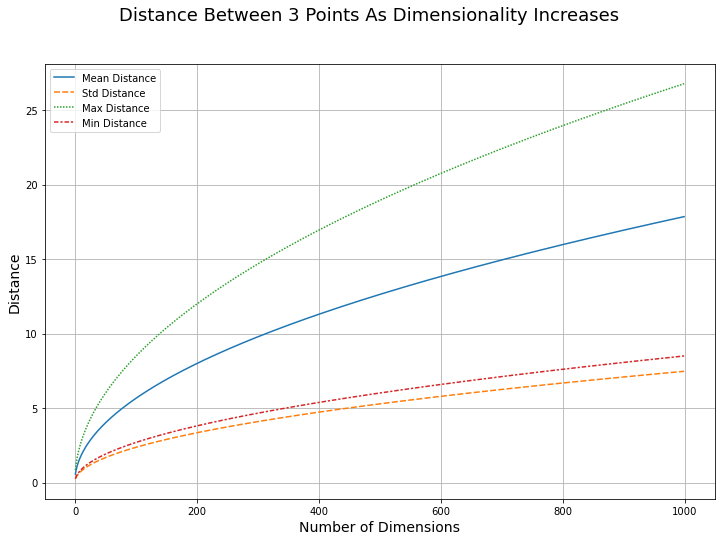

In [27]:
distance_per_dimension(num_points=3, num_dims=1000, repeat_array=1)